# This is the data cleaning Notebok for the project

In [843]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

In [844]:
df = pd.read_excel("marketing_data.xlsx")

## Data Profiling

In [845]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
Response                 int64
Complain                 int64
dtype: object

## Data Preprocessing

In [846]:
# Converting year of birth into age
current_year = datetime.now().year
df['Age'] = current_year - df['Year_Birth']
print(df[['Age', 'Year_Birth']])
print(df['Age'].unique())

      Age  Year_Birth
0      54        1970
1      63        1961
2      66        1958
3      57        1967
4      35        1989
...   ...         ...
2235   48        1976
2236   47        1977
2237   48        1976
2238   46        1978
2239   55        1969

[2240 rows x 2 columns]
[ 54  63  66  57  35  70  77  45  65  43  55  47  64  58  48  59  68  49
  53  38  52  50  34  37  40  56  69  41  51  46  72  62  60  42  61  67
  44  79  75  76  71  78  39  32  80  73  36  74  30  31  33 131  28  29
 125  81  83  84 124]


In [847]:
# Fixing the format for Dt_customer
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='mixed')
print(df.shape)
df = df[(df['Dt_Customer'].dt.year - df['Year_Birth']) > 18]
print(df.shape)
df['Dt_Customer'] = df['Dt_Customer'].astype(str)
print(df)

(2240, 23)
(2234, 23)
         ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
0      1826        1970  Graduation       Divorced  84835.0        0   
1         1        1961  Graduation         Single  57091.0        0   
2     10476        1958  Graduation        Married  67267.0        0   
3      1386        1967  Graduation       Together  32474.0        1   
4      5371        1989  Graduation         Single  21474.0        1   
...     ...         ...         ...            ...      ...      ...   
2235  10142        1976         PhD       Divorced  66476.0        0   
2236   5263        1977    2n Cycle        Married  31056.0        1   
2237     22        1976  Graduation       Divorced  46310.0        1   
2238    528        1978  Graduation        Married  65819.0        0   
2239   4070        1969         PhD        Married  94871.0        0   

      Teenhome Dt_Customer  Recency  MntWines  ...  MntSweetProducts  \
0            0  2014-06-16        0      

In [848]:
df['Total_Spent'] = (df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds'])/6
df['BuyingPower'] = df['Total_Spent'] / df['Income'] 

<Axes: xlabel='BuyingPower', ylabel='Income'>

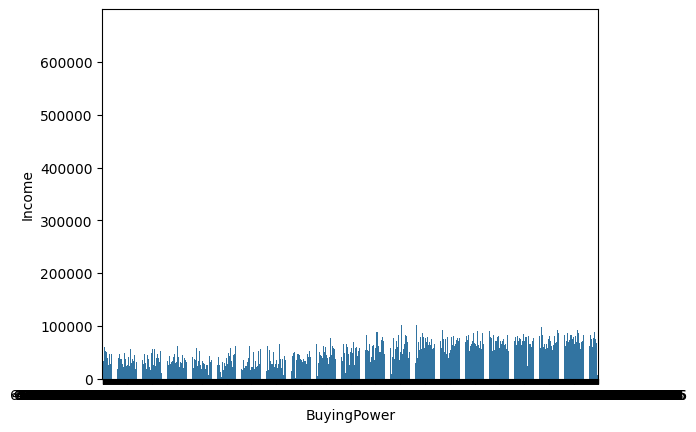

In [849]:
df.sort_values(by='Income', ascending=True, inplace=True)
sns.barplot(x='BuyingPower', y='Income', data=df)

In [850]:
df['BuyingPower'].head()

1466    0.000771
961     0.117831
1291    0.000238
663     0.000373
14      0.013512
Name: BuyingPower, dtype: float64

## Filling all null income values

In [851]:
df['Income'].head()

1466    1730.0
961     2447.0
1291    3502.0
663     4023.0
14      4428.0
Name: Income, dtype: float64

In [852]:
# Graduation = df[df['Education'] == 'Graduation']
# Graduation.head(50)

unique_values = df['Education'].unique()
print(unique_values)

['Graduation' 'PhD' 'Master' '2n Cycle' 'Basic']


In [853]:
df['Marital_Status'].unique()

array(['Divorced', 'Married', 'Single', 'Together', 'Widow', 'Alone',
       'YOLO', 'Absurd'], dtype=object)

In [854]:
df['Marital_Status'] = df['Marital_Status'].replace(['YOLO', 'Alone'], 'Single')
df['Marital_Status'] = df['Marital_Status'].replace(['Absurd'], 'Married')

In [855]:
df['Marital_Status'].unique()

array(['Divorced', 'Married', 'Single', 'Together', 'Widow'], dtype=object)

In [856]:
df['Education'] = df['Education'].replace(['2n Cycle'], 'n_cycle')

In [857]:
Graduation_mean = df[df['Education'] == 'Graduation']
Graduation_mean = Graduation_mean['Income'].mean()
print(Graduation_mean)

52656.84290843806


In [858]:
PhD_mean = df[df['Education'] == 'PhD']
PhD_mean = PhD_mean['Income'].mean()
print(PhD_mean)

56145.31392931393


In [859]:
TwoN_Cycle_mean = df[df['Education'] == 'n_Cycle']
TwoN_Cycle_mean = TwoN_Cycle_mean['Income'].mean()
print(TwoN_Cycle_mean)

nan


In [860]:
Master_mean = df[df['Education'] == 'Master']
Master_mean = Master_mean['Income'].mean()
print(Master_mean)

52917.53424657534


In [861]:
Basic_mean = df[df['Education'] == 'Basic']
Basic_mean = Basic_mean['Income'].mean()
print(Basic_mean)

20417.30188679245


In [862]:
df['Total_Children'] = df.loc[:, 'Kidhome'] + df.loc[:, 'Teenhome']
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Total_Spent,BuyingPower,Total_Children
1466,6862,1971,Graduation,Divorced,1730.0,0,0,2014-05-18,65,1,...,0,0,0,20,0,0,53,1.333333,0.000771,0
961,5376,1979,Graduation,Married,2447.0,1,0,2013-06-01,42,1,...,0,28,0,1,0,0,45,288.333333,0.117831,1
1291,11110,1973,Graduation,Single,3502.0,1,0,2013-04-13,56,2,...,0,0,0,14,0,0,51,0.833333,0.000238,1
663,9931,1963,PhD,Married,4023.0,1,1,2014-06-23,29,5,...,0,0,0,19,0,0,61,1.500000,0.000373,2
14,10311,1969,Graduation,Married,4428.0,0,1,2013-05-10,0,16,...,25,0,0,1,0,0,55,59.833333,0.013512,1


In [863]:
null_income = df[df['Income'].isnull()]
# null_income = null_income.isnull().sum()
null_income['Income'][null_income['Education'] == 'Graduation'] = Graduation_mean
null_income['Income'][null_income['Education'] == 'PhD'] = PhD_mean
null_income['Income'][null_income['Education'] == '2n Cycle'] = TwoN_Cycle_mean
null_income['Income'][null_income['Education'] == 'Master'] = Master_mean
null_income['Income'][null_income['Education'] == 'Basic'] = Basic_mean
print(null_income)

         ID  Year_Birth   Education Marital_Status        Income  Kidhome  \
134    8996        1957         PhD        Married  56145.313929        2   
262    1994        1983  Graduation        Married  52656.842908        1   
394    3769        1972         PhD       Together  56145.313929        1   
449    5255        1986  Graduation         Single  52656.842908        1   
525    8268        1961         PhD        Married  56145.313929        0   
590   10629        1973     n_cycle        Married           NaN        1   
899   10475        1970      Master       Together  52917.534247        0   
997    9235        1957  Graduation         Single  52656.842908        1   
1096   4345        1964     n_cycle         Single           NaN        1   
1185   7187        1969      Master       Together  52917.534247        1   
1213   8720        1978     n_cycle       Together           NaN        0   
1312   8557        1982  Graduation         Single  52656.842908        1   

C:\Users\nigel\AppData\Local\Temp\ipykernel_19692\1739440520.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  null_income['Income'][null_income['Education'] == 'Graduation'] = Graduation_mean
C:\Users\nigel\AppData\Local\Temp\ipykernel_19

In [864]:
df['Income'][df['Income'].isnull()] = null_income['Income']
df.head(50)

C:\Users\nigel\AppData\Local\Temp\ipykernel_19692\140808848.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Income'][df['Income'].isnull()] = null_income['Income']
C:\Users\nigel\AppData\Local\Temp\ipykernel_19692\140808848.py:1: Set

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Total_Spent,BuyingPower,Total_Children
1466,6862,1971,Graduation,Divorced,1730.0,0,0,2014-05-18,65,1,...,0,0,0,20,0,0,53,1.333333,0.000771,0
961,5376,1979,Graduation,Married,2447.0,1,0,2013-06-01,42,1,...,0,28,0,1,0,0,45,288.333333,0.117831,1
1291,11110,1973,Graduation,Single,3502.0,1,0,2013-04-13,56,2,...,0,0,0,14,0,0,51,0.833333,0.000238,1
663,9931,1963,PhD,Married,4023.0,1,1,2014-06-23,29,5,...,0,0,0,19,0,0,61,1.500000,0.000373,2
14,10311,1969,Graduation,Married,4428.0,0,1,2013-05-10,0,16,...,25,0,0,1,0,0,55,59.833333,0.013512,1
456,3955,1965,Graduation,Divorced,4861.0,0,0,2014-06-22,20,2,...,0,0,0,14,0,0,59,1.000000,0.000206,0
299,9303,1976,Graduation,Married,5305.0,0,1,2013-07-30,12,12,...,1,0,0,13,0,0,48,5.333333,0.001005,1
1533,5899,1950,PhD,Together,5648.0,1,1,2014-03-13,68,28,...,1,0,0,20,0,0,74,8.166667,0.001446,2
60,4246,1982,Master,Single,6560.0,0,0,2013-12-12,2,67,...,1,0,1,17,0,0,42,62.166667,0.009477,0
1721,4303,1957,PhD,Together,6835.0,0,1,2012-08-12,76,107,...,0,0,1,20,0,0,67,22.833333,0.003341,1


## Saving the cleaned data

In [865]:
df.to_excel('Cleaned_Data.xlsx')

In [866]:
df.count()

ID                     2234
Year_Birth             2234
Education              2234
Marital_Status         2234
Income                 2231
Kidhome                2234
Teenhome               2234
Dt_Customer            2234
Recency                2234
MntWines               2234
MntFruits              2234
MntMeatProducts        2234
MntFishProducts        2234
MntSweetProducts       2234
MntGoldProds           2234
NumDealsPurchases      2234
NumWebPurchases        2234
NumCatalogPurchases    2234
NumStorePurchases      2234
NumWebVisitsMonth      2234
Response               2234
Complain               2234
Age                    2234
Total_Spent            2234
BuyingPower            2210
Total_Children         2234
dtype: int64

In [867]:
df = df[df['Income'] < 200000]
df.count()


ID                     2230
Year_Birth             2230
Education              2230
Marital_Status         2230
Income                 2230
Kidhome                2230
Teenhome               2230
Dt_Customer            2230
Recency                2230
MntWines               2230
MntFruits              2230
MntMeatProducts        2230
MntFishProducts        2230
MntSweetProducts       2230
MntGoldProds           2230
NumDealsPurchases      2230
NumWebPurchases        2230
NumCatalogPurchases    2230
NumStorePurchases      2230
NumWebVisitsMonth      2230
Response               2230
Complain               2230
Age                    2230
Total_Spent            2230
BuyingPower            2209
Total_Children         2230
dtype: int64

In [868]:
plt.scatter(df['Income'], df['BuyingPower'])

In [ ]:
df['TotalPurchases'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

In [ ]:
df['Interest'] = df['NumWebVisitsMonth'] + df['Recency'] 

In [ ]:
df = df[df['BuyingPower']< 0.05]

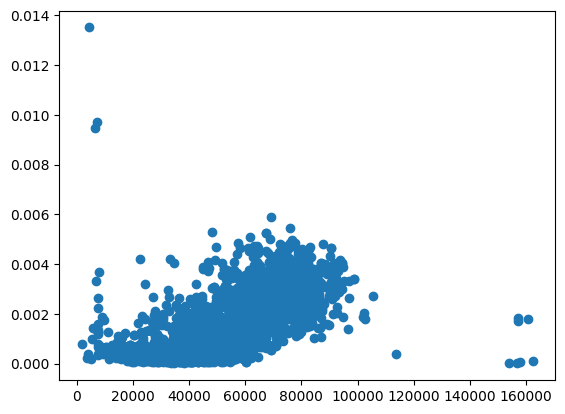

In [ ]:
plt.scatter(df['Income'], df['BuyingPower'])    

In [ ]:
df.to_excel('Threshold_Data.xlsx')